<a href="https://colab.research.google.com/github/ivbhv/DS_final_project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project - Recommendation system for products on an online retail webiste.**

# **Problem Statement :-**

 Analyze an online retail data set and Build  recommendation system to provide recommendation to user.

# **Abstract**

Building recommendation systems for things sold online was the goal of this research. We assessed the top ten products to suggest to a user using a collaborative filtering methodology and a customer-item based matrix. Tools and Skills  Python, Recommender Systems, Collaborative Filtering

# **Approach**


1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics)

2. Prepare the data. Data cleaning involved

3. Split the data randomly into train and test dataset. 

4. Create a Customer-Item Matrix.

5. Build User based Collaborative Filtering model.

6. Build Item-Based Collaborative Filtering

7. Get top - K ( K = 10) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 10 new products.

8. Summarise insights.




* Importing required libraries of python to work on the dataset




In [270]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotnine as pn

* read the data with the help of python.

In [306]:
df = pd.read_csv('https://raw.githubusercontent.com/ivbhv/DS_final_project/main/OnlineRetail.csv',encoding= 'unicode_escape', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [272]:
# This shows the count Rows and columns of dataset
df.shape

(541909, 8)

* Here are some negative quantities because of the canceled or refunded orders. I will remove them from the data set.

In [273]:
# #filtering out negative quantities
df = df.loc[df['Quantity'] > 0]
df.shape

(531285, 8)

In [274]:
# Get the type of data we have.
df['CustomerID'].describe()

count    397924.000000
mean      15294.315171
std        1713.169877
min       12346.000000
25%       13969.000000
50%       15159.000000
75%       16795.000000
max       18287.000000
Name: CustomerID, dtype: float64

In [275]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133361
Country             0
dtype: int64

* It seems we are missing a lot of CustomerID data That can be for multiple reasons and considering we are doing customer segementation we need CustomerID, so i will just drop rows where ID is empty and for Description considering we have StockCode we could fill that up if all 1454 are not from same item and one is causing problems

In [276]:
df['CustomerID'].isna().sum()

133361

In [277]:
df.loc[df['CustomerID'].isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [278]:
#df.dropna(subset=['CustomerID'],inplace=True) it is not smart to use inplace. We should always reassign

df = df.dropna(subset=['CustomerID'])

* We don't have Total column so i will add one for comparison later.

In [279]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

<ipython-input-279-18878337d6d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Time Series Analysis**

Before looking at the product-level data, I will explore overall time series trends in the revenue and the number of orders to understand whether the business is growing or shrinking over time.

First, let's look at the number of orders over time.

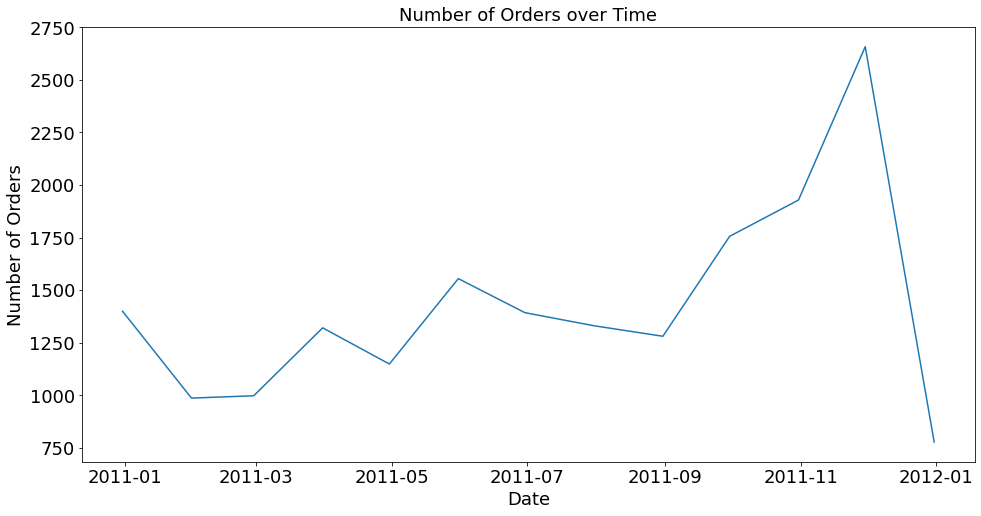

In [280]:
# convert InvoiceDate to month and group by it
num_invoices = df.groupby(pd.Grouper(key='InvoiceDate', freq='M')).InvoiceNo.nunique().reset_index()

# plot the results
plt.figure(figsize=(16,8))
plt.plot(num_invoices['InvoiceDate'], num_invoices['InvoiceNo'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Orders', fontsize=18)
plt.title('Number of Orders over Time', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


* Here is the sudden drop in the number of orders in December 2011. This is because we only have the data from December 1 to December 9. I'm going to remove the data from December for my analysis. Otherwise, it would be a misrepresentation.

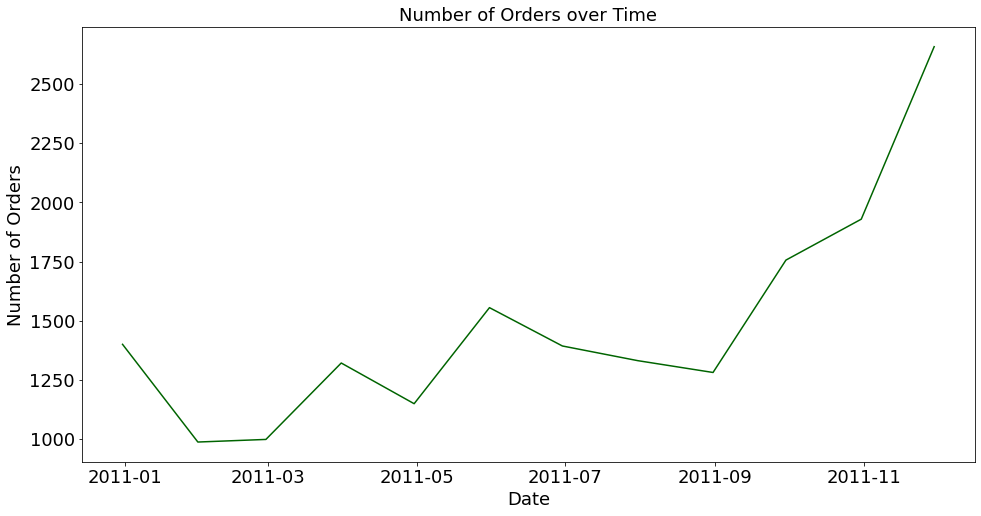

In [281]:
# removing this data from the data set
df = df[df["InvoiceDate"] < "2011-12-01"]

num_invoices = df.groupby(pd.Grouper(key="InvoiceDate", freq="M")).InvoiceNo.nunique()

# plotting again

plt.figure(figsize=(16,8))
plt.plot(num_invoices.index, num_invoices.values, color="darkgreen")
plt.title("Number of Orders over Time", size=18)
plt.ylabel("Number of Orders", size=18)
plt.xlabel("Date", size=18)
plt.tick_params(axis='x', which='both', labelsize=18)
plt.tick_params(axis='y', which='both', labelsize=18)

* We can observe that starting in September 2011, there was a noticeable increase in the number of orders, which peaked in November 2011. That can have occurred as a result of seasonal effects or a developing business. To learn more in this situation, it is imperative that we consider the prior years. 

Now let's examine the monthly sales.

(array([ 291829.00000463,  437926.00000463,  584023.00000463,
         730120.00000463,  876217.00000463, 1022314.00000463,
        1168411.00000463, 1314508.00000463]),
 <a list of 8 Text major ticklabel objects>)

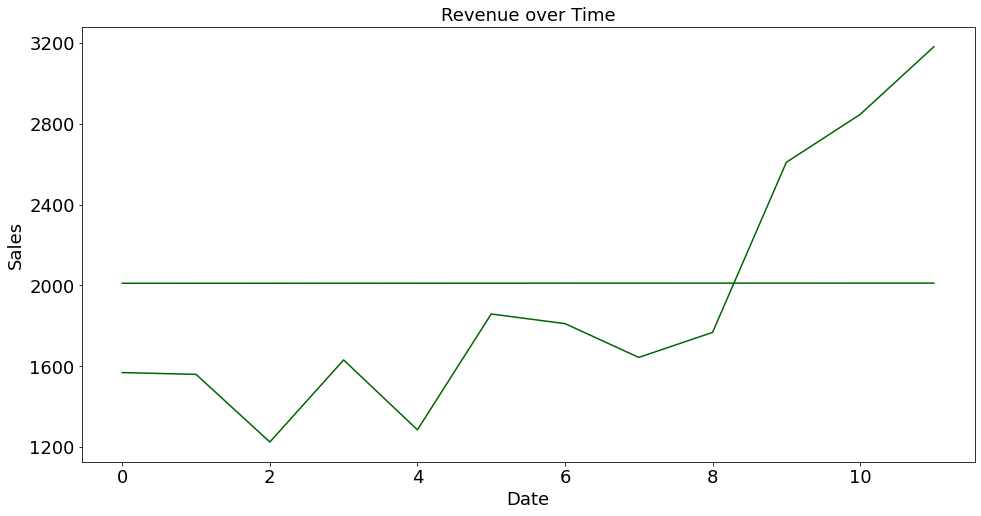

In [282]:
# calculate the sales column
df = df.assign(Sales=df['Quantity']*df['UnitPrice'])

revenue = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Sales'].sum().reset_index()
plt.figure(figsize=(16,8))
plt.plot(revenue.index, revenue.values, color='darkgreen')
plt.title("Revenue over Time", size=18)
plt.ylabel("Sales", size=18)
plt.xlabel("Date", size=18)
plt.xticks(size=18)
plt.yticks(size=18)




* The pattern here is the same as it was with the quantity of orders. Understanding overall business success is aided by this examination of orders and revenue.

**Repeat Customers**

Every successful business knows how important it is to retain customers to have a steady stream of sales from them. Let's see how many sales are from existing customers for this online retail business that I'm analyzing.

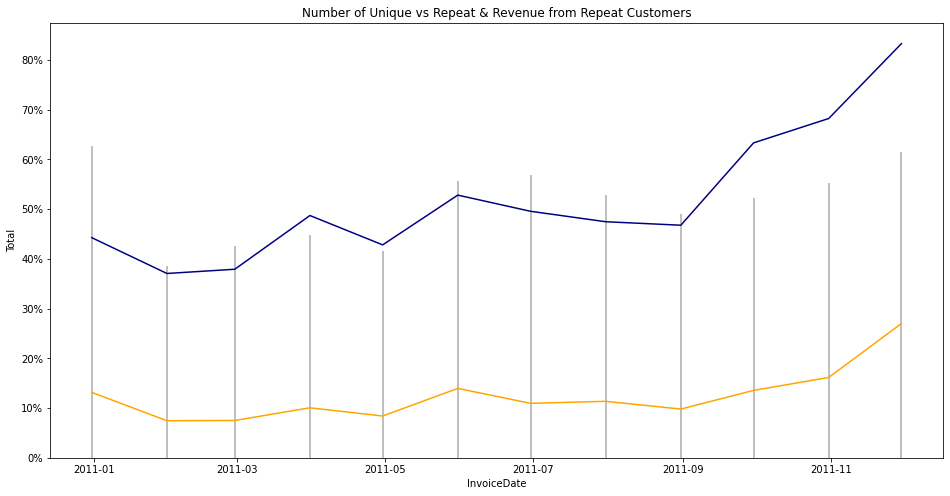

In [283]:
# aggregating data so that one row represents one purchase order
invoice = df.groupby(['InvoiceNo', 'InvoiceDate']).agg(CustomerID = pd.NamedAgg(column ='CustomerID', aggfunc='max'), Sales = pd.NamedAgg(column ='Sales', aggfunc='sum')).reset_index()

# aggregating data into months
invoice_customer = invoice.groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'CustomerID']).agg(Count = pd.NamedAgg(column ='InvoiceNo', aggfunc=lambda x: x.nunique()), Sales = pd.NamedAgg(column ='Sales', aggfunc='sum')).reset_index()

# filter out customer with 1 order and NA CustomerId
repeat_customer = invoice_customer[~pd.isnull(invoice_customer["CustomerID"]) &(invoice_customer.Count > 1)]
repeat_customer = repeat_customer.groupby(['InvoiceDate']).agg(Count = pd.NamedAgg(column ='CustomerID', aggfunc=lambda x: x.nunique()), Sales = pd.NamedAgg(column ='Sales', aggfunc='sum')).reset_index()

# total number of monthyl customer
unique_customers = df.groupby([pd.Grouper(key='InvoiceDate', freq='M')]).agg(Count = pd.NamedAgg(column ='CustomerID', aggfunc=lambda x: x.nunique())).reset_index()

# find the percentage of monthly revenue that are attributed to the repeat customers
repeat_customer['Perc'] = repeat_customer['Sales'] / revenue['Sales'] * 100.0

# append unique customers
repeat_customer['Total'] = unique_customers['Count']

# visualize repeat customers data

plt.figure(figsize=(16,8))
plt.plot(repeat_customer['InvoiceDate'], repeat_customer['Total'], color='navy')
plt.plot(repeat_customer['InvoiceDate'], repeat_customer['Count'], color='orange')
plt.bar(repeat_customer['InvoiceDate'], repeat_customer['Perc']*20, color='gray', alpha=0.5)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0f}%'.format(x/20)))
plt.title('Number of Unique vs Repeat & Revenue from Repeat Customers')
plt.xlabel('InvoiceDate')
plt.ylabel('Total')
plt.show()

Blue line - Number of unique (total) customers

Yellow line - Number of repeat customers

Gray bars - represent the revenue from repeat customers

We see that repeat customers are about 20-30 % of the total monthly customers. But 40-50% of revenue comes from these repeat customers. Here we see a great example of why it is important to retain existing customers.

**Trending Products**

I'm going to explore how customers interact with company products and take a look at the top five best-sellers over time.

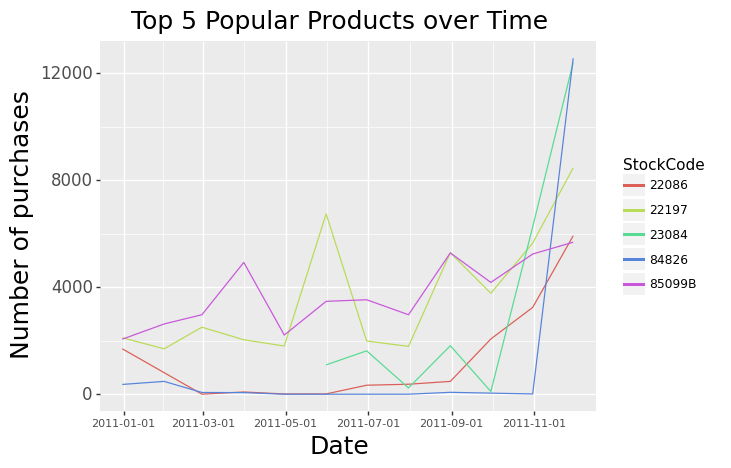

<ggplot: (8751563637465)>

In [284]:
# number of items sold for each product for each period
popular_products = df.groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'StockCode']).agg(Quantity = pd.NamedAgg(column ='Quantity', aggfunc='sum')).reset_index()

#let's find top 5 items sold in November 2011 (most recent trends)
top_5 = popular_products[(popular_products.InvoiceDate=="2011-11-30")].sort_values(by=['Quantity'], ascending=[False])[:5]

# #here we take the data from PopularProducts data frame with the stock codes in Top5
top_5_monthly = popular_products[popular_products['StockCode'].isin(top_5['StockCode'])]

pn.ggplot(top_5_monthly, pn.aes(x='InvoiceDate', y='Quantity', color='StockCode')) + pn.geom_line() + pn.labs(title="Top 5 Popular Products over Time") + pn.ylab("Number of purchases") + pn.xlab("Date") + pn.theme(axis_text_x=pn.element_text(size=8), axis_text_y=pn.element_text(size=12), axis_title=pn.element_text(size=18), plot_title=pn.element_text(size=18))

* Here we see top-5 trending products with the stock codes 22086, 22197, 23084, 84826, and 85099B. I can recommend these popular products in marketing emails or ads to improve engagement. New customers might be more interested in these items and more likely to purchase them. So this can help to increase the conversion rate of your online campaigns or conversion rates of your web pages with these products.

**Top revenue**

We can see the top contries from were we are getting the sales.

In [285]:
px.pie(df.groupby('Country').TotalPrice.sum().reset_index()[:20], values='TotalPrice', names='Country', 
      title='TOP BEST 20 COUNTRIES BY SALES')

#Recommending Products

Collaborative filtering, which I'm going to do in this analysis, is a method to recommend products based on previous user behaviors (viewed pages, purchased products, given ratings). The idea is to find similarities between users and products/content, and recommend the most similar products or content. For example, if one user purchased a white t-shirt, blue jeans, and a hat and the other user purchased a white t-shirt, blue jeans, and gloves, then the first user is more likely to buy gloves and the second - a hat (because of their similarities in purchasing products).

*  I need to build a customer-to-item matrix which is tabular data where each column represents each product, each row represents a customer, and values in each cell represent whether a customer purchased the given product or not.

In [286]:
customer_item_matrix = df.pivot_table(index='CustomerID',columns='StockCode',values='Quantity',aggfunc='sum').applymap(lambda x: 1 if x>0 else 0)

**User-based vs. Item-based collaborative filtering**

I will explore two approaches to building a product recommendation system:

1. User-based approach - looking for similarities between users based on their product purchase history.

2. Item-based approach - looking for similarities between products based on which items are often bought together with other items.

Let's start with a user-based approach.

# User Based collaborative filtering

In [287]:
customer_item_matrix.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


* This it the customer-item matrix that I created on the previous step. It shows whether the given customer bought (1) or not(0) the given product. What I need to do now is to compute cosine similarities between customers.

In [288]:
from sklearn.metrics.pairwise import cosine_similarity
user_to_user_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix))
user_to_user_sim_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,4288,4289,4290,4291,4292,4293,4294,4295,4296,4297
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,1.000000,0.063960,0.035112,0.048507,0.039057,0.0,0.026261,0.138675,0.096152,...,0.0,0.030151,0.053452,0.0,0.033333,0.063246,0.0,0.000000,0.111847,0.013019
2,0.0,0.063960,1.000000,0.024953,0.051709,0.027756,0.0,0.027995,0.118262,0.146427,...,0.0,0.064282,0.113961,0.0,0.000000,0.000000,0.0,0.000000,0.158972,0.083269
3,0.0,0.035112,0.024953,1.000000,0.056773,0.137137,0.0,0.030737,0.032461,0.144692,...,0.0,0.105868,0.000000,0.0,0.039014,0.000000,0.0,0.044237,0.138179,0.030475
4,0.0,0.048507,0.051709,0.056773,1.000000,0.031575,0.0,0.000000,0.000000,0.033315,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.045211,0.000000


In [289]:
user_to_user_sim_matrix.columns = customer_item_matrix.index
user_to_user_sim_matrix['CustomerID'] = customer_item_matrix.index
user_to_user_sim_matrix = user_to_user_sim_matrix.set_index('CustomerID')
user_to_user_sim_matrix.head()

CustomerID,12346.0,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
12347.0,0.0,1.000000,0.063960,0.035112,0.048507,0.039057,0.0,0.026261,0.138675,0.096152,...,0.0,0.030151,0.053452,0.0,0.033333,0.063246,0.0,0.000000,0.111847,0.013019
12348.0,0.0,0.063960,1.000000,0.024953,0.051709,0.027756,0.0,0.027995,0.118262,0.146427,...,0.0,0.064282,0.113961,0.0,0.000000,0.000000,0.0,0.000000,0.158972,0.083269
12349.0,0.0,0.035112,0.024953,1.000000,0.056773,0.137137,0.0,0.030737,0.032461,0.144692,...,0.0,0.105868,0.000000,0.0,0.039014,0.000000,0.0,0.044237,0.138179,0.030475
12350.0,0.0,0.048507,0.051709,0.056773,1.000000,0.031575,0.0,0.000000,0.000000,0.033315,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.045211,0.000000


* As you can guess, the closer the cosine similarity between two customers to 1, the more likely those customers buy similar products.

Let's pick one customer as an example. CustomerID = 12350.

In [290]:
user_to_user_sim_matrix.loc[12350.0].sort_values(ascending = False)

CustomerID
12350.0    1.000000
17935.0    0.183340
12414.0    0.181902
12652.0    0.175035
16754.0    0.171499
             ...   
14882.0    0.000000
14883.0    0.000000
14885.0    0.000000
14886.0    0.000000
18287.0    0.000000
Name: 12350.0, Length: 4298, dtype: float64

In [291]:
# Items bought by User A
items_bought_by_A = set(customer_item_matrix.loc[12350.0].iloc[customer_item_matrix.loc[12350.0].to_numpy().nonzero()].index)

In [292]:
# Items bought by User B (I pick a customer with ID=17935)
items_bought_by_B = set(customer_item_matrix.loc[17935.0].iloc[customer_item_matrix.loc[17935.0].to_numpy().nonzero()].index)

* let's find the items that the customer B didn't buy so we can recommend these items to buy for B

In [293]:
items_to_recommend_User_B = items_bought_by_A - items_bought_by_B

**Recommedation to user after picking random customer ID based on items bought by user A**

In [294]:
df.loc[
    df['StockCode'].isin(items_to_recommend_User_B),
    ['StockCode','Description']
].drop_duplicates().set_index('StockCode')

,Description
StockCode,
21832,CHOCOLATE CALCULATOR
21915,RED HARMONICA IN BOX
22620,4 TRADITIONAL SPINNING TOPS
79066K,RETRO MOD TRAY
21864,UNION JACK FLAG PASSPORT COVER
79191C,RETRO PLASTIC ELEPHANT TRAY
21908,CHOCOLATE THIS WAY METAL SIGN
20615,BLUE POLKADOT PASSPORT COVER
20652,BLUE POLKADOT LUGGAGE TAG


* Here we have a list of products that we can recommend to the customer B (with CustomerID=17935).

* By using this user-based collaborative filtering, we can customize our marketing messages (email, ads, articles) and drive more conversions from our customers.

* There is a disadvantage of this method though. We only can recommend products based on a customer purchase history. So we can not use this method for new customers. To manage this problem, we can use **item-based collaborative** filtering.

* Now we will find similarities between items as we did before with customers.

# Item-Based Collaborative Filtering

In [295]:
# item-to-item similarity matrix

item_item_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix.T))
item_item_sim_matrix.columns = customer_item_matrix.T.index
item_item_sim_matrix['StockCode'] = customer_item_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('StockCode')
item_item_sim_matrix.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.0,0.094868,0.091287,0.0,0.000000,0.091287,0.062932,0.099449,0.097590,...,0.0,0.0,0.0,0.0,0.0,0.029361,0.0,0.067250,0.0,0.070382
10080,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.033113,0.045655,0.048099,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.016263,0.0,0.000000
10120,0.094868,0.0,1.000000,0.115470,0.0,0.000000,0.057735,0.059702,0.041931,0.061721,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.070888,0.0,0.011128
10123C,0.091287,0.0,0.115470,1.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
10124A,0.000000,0.0,0.000000,0.000000,1.0,0.447214,0.064550,0.044499,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000


* Here we see another matrix that shows cosine similarities between defferent items.

* Imagine you have a new customer who just bought a product with StockCode 23166. We want to include some products that this customer is most likely to purchase in our online retargeting campaign. Here what we can do:

In [296]:
# find top10 most similar products to the product with StockCode 23166
top_10_similar_items = list(item_item_sim_matrix.loc['23166'].sort_values(ascending=False).iloc[:10].index)

In [297]:
df.loc[
    df['StockCode'].isin(top_10_similar_items), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode').loc[top_10_similar_items]

,Description
StockCode,
23166,MEDIUM CERAMIC TOP STORAGE JAR
23165,LARGE CERAMIC TOP STORAGE JAR
23167,SMALL CERAMIC TOP STORAGE JAR
22993,SET OF 4 PANTRY JELLY MOULDS
23307,SET OF 60 PANTRY DESIGN CAKE CASES
22722,SET OF 6 SPICE TINS PANTRY DESIGN
22720,SET OF 3 CAKE TINS PANTRY DESIGN
23243,SET OF TEA COFFEE SUGAR TINS PANTRY
22961,JAM MAKING SET PRINTED


* The first item in this list is the one the target buyer just purchased. Other consumers who have purchased the first product frequently purchase the remaining 10 products. 

* Therefore, we can use these goods to suggest them to our prospective client. Conversion rates from customers typically increase when marketing messages are personalized and include targeted product recommendations. You can provide both new and returning consumers with product recommendations by employing an item-based collaborative filtering algorithm.

# Summary


1. I examined the state of the company's overall operations and discovered that it is expanding (in the number of orders and revenue). 

2. I discovered that the company generates revenue at a rate of 40–50% and has 20–30% recurring consumers. One of the best methods to help your business expand is through keeping clients. 

3. I found the top 5 trending items that the business might use in its marketing campaigns to draw in more clients. 

4. I demonstrated how the business can tailor marketing campaigns, emails, and more using collaborative filtering and product suggestions.